In [1]:
from langchain_community.chat_models import ChatOllama
from langchain_community.embeddings import OllamaEmbeddings

# LLM cho chat
llm = ChatOllama(
    model="gemma3:1b",
    base_url="http://localhost:11434"
)

# Embedding model
embedding = OllamaEmbeddings(
    model="embeddinggemma:300m",
    base_url="http://localhost:11434"
)

c:\Users\xgear\miniconda3\envs\intern\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\xgear\AppData\Local\Temp\ipykernel_31604\3321198127.py:5: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the `langchain-ollama package and should be used instead. To use it run `pip install -U `langchain-ollama` and import as `from `langchain_ollama import ChatOllama``.
  llm = ChatOllama(
C:\Users\xgear\AppData\Local\Temp\ipykernel_31604\3321198127.py:11: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the `langchain-ollama package and should be used instead. To use it run `pip install -U `langcha

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
LANGCHAIN_API_KEY = os.getenv('LANGCHAIN_API_KEY')
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = LANGCHAIN_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

In [3]:
import os
import re

from IPython.display import display, Image
from rich import print as rprint
from rich.markdown import Markdown
from rich.pretty import Pretty
from rich.text import Text

In [4]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
articles = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

loader = WebBaseLoader(
    web_paths=articles,
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
len(docs)

3

In [6]:
print(docs[0].page_content[:1000])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Short-term memory: I 

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [8]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
splits = text_splitter.split_documents(docs)
len(splits)

174

In [9]:
from langchain_core.vectorstores import InMemoryVectorStore

In [10]:
vectorstore = InMemoryVectorStore(embedding)
doc_ids = vectorstore.add_documents(documents=splits)
len(doc_ids), len(vectorstore.store)

(174, 174)

In [11]:
retriever = vectorstore.as_retriever()

# RAG

In [ ]:
import operator
from typing import Annotated, Literal, TypedDict

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.runnables import chain
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel, Field
import json

In [13]:
rag_prompt_template = """Answer the following question based on this context:

{context}

Question: {question}
"""

grading_prompt_template = """You are a grader assessing relevance of a retrieved document to a user question. 
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
Give a binary score to indicate whether the document is relevant to the question.

Retrieved document:
{document}

User question:
{question}"""
query_rewriting_prompt_template = """You a question re-writer that converts an input question to a better version that is optimized for web search. 
Look at the input and try to reason about the underlying semantic intent / meaning.

Here is the initial question:
{question}

Formulate an improved question."""

In [ ]:


class DocumentGrade(BaseModel):
    chain_of_thought: str = Field(description="Reasoning")
    is_required: bool = Field(description="Is Document required")

class DocumentGrade(BaseModel):
    chain_of_thought: str = Field(
        ..., description="Step by step reasoning to check if the document is relevant to the question"
    )
    is_relevant: bool = Field(
        description="Document is relevant to the question"
    )


@chain
def grade_document(document, question):
    grading_prompt = f"""
    You are a strict document relevance grader.
    Return a JSON in this exact format:

    {{
        "chain_of_thought": "...",
        "is_relevant": true or false
    }}

    DOCUMENT:
    {document}

    QUESTION:
    {question}
    """


    response = llm.invoke(grading_prompt)

    content = response.content.strip().strip("```json").strip("```")
    return DocumentGrade(**json.loads(content))

In [15]:

def WebSearchQuery(question):
    prompt = f"""
    You are a web search query optimizer.

    Return ONLY a JSON object in this format:
    {{
        "chain_of_thought": "your reasoning",
        "web_search_query": "optimized query"
    }}

    Question: {question}
    """

    resp = llm.invoke(prompt)

    raw = resp.content if hasattr(resp, "content") else resp

    cleaned = (
        raw.replace("```json", "")
           .replace("```", "")
           .strip()
    )
    return json.loads(cleaned)

In [16]:
web_search_tool = TavilySearchResults(k=4)
rprint(web_search_tool.input_schema.schema())

C:\Users\xgear\AppData\Local\Temp\ipykernel_31604\2226099129.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=4)
C:\Users\xgear\AppData\Local\Temp\ipykernel_31604\2226099129.py:2: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  rprint(web_search_tool.input_schema.schema())


{
    'description': 'Input for the Tavily tool.',
    'properties': {'query': {'description': 'search query to look up', 'title': 'Query', 'type': 'string'}},
    'required': ['query'],
    'title': 'TavilyInput',
    'type': 'object'
}

In [17]:
def format_docs(docs: list[Document]) -> list[str]:
    return "\n\n".join(doc.page_content for doc in docs)

In [18]:
class State(TypedDict):
    question: str
    documents: list[Document]
    grades: list[DocumentGrade]
    is_web_search_required: bool
    web_search_query: str
    context: Annotated[list[Document], operator.add]
    answer: str

In [19]:
def retrieve(state: State):
    question = state["question"]
    documents = retriever.invoke(question)
    return {"documents": documents}


def grade_documents(state: State):
    question = state["question"]
    documents = state["documents"]

    grades = grade_document.batch(
        documents, question=question
    )
    filtered_documents = [document for (document, grade) in zip(documents, grades) if grade.is_relevant]
    is_web_search_required = len(filtered_documents) < len(documents)
            
    return {"context": filtered_documents, "grades": grades, "is_web_search_required": is_web_search_required}


def check_documents_relevance(state: State) -> Literal["rewrite_query", "generate_answer"]:
    is_web_search_required = state["is_web_search_required"]

    if is_web_search_required:
        return "rewrite_query"
    else:
        return "generate_answer"


def rewrite_query(state: State):
    question = state["question"]
    optimized = WebSearchQuery(question)
    return {"web_search_query": optimized["web_search_query"]}


def web_search(state: State):
    query = state["web_search_query"]
    results = web_search_tool.invoke({"query": query})
    documents = [Document(page_content=result["content"]) for result in results]
    return {"context": documents}


def generate_answer(state: State):
    docs_content = format_docs(state["context"])
    rag_prompt = rag_prompt_template.format(
        question=state["question"],
        context=docs_content
    )
    response = llm.invoke([
        HumanMessage(content=rag_prompt)
    ])
    return {"answer": response.content}

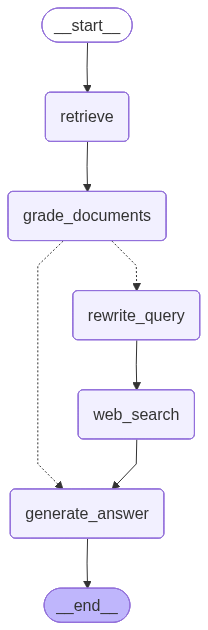

In [20]:
graph_builder = StateGraph(State)

graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("grade_documents", grade_documents)
graph_builder.add_node("rewrite_query", rewrite_query)
graph_builder.add_node("web_search", web_search)
graph_builder.add_node("generate_answer", generate_answer)

graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "grade_documents")
graph_builder.add_conditional_edges(
    "grade_documents", 
    check_documents_relevance
)
graph_builder.add_edge("rewrite_query", "web_search")
graph_builder.add_edge("web_search", "generate_answer")
graph_builder.add_edge("generate_answer", END)

graph = graph_builder.compile()
graph

In [21]:
query = "What are common types of agent memory?"

response = graph.invoke({"question": query})
rprint(response)
rprint(Markdown(response["answer"]))

{
    'question': 'What are common types of agent memory?',
    'documents': [
        Document(
            id='78d81690-65bd-4ab1-901b-a640b3073c2f',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Comparison of AD, ED, source policy and RL^2 on environments that require memory and 
exploration. Only binary reward is assigned. The source policies are trained with A3C for "dark" environments and 
DQN for watermaze.(Image source: Laskin et al. 2023)\n\nComponent Two: Memory#\n(Big thank you to ChatGPT for 
helping me draft this section. I’ve learned a lot about the human brain and data structure for fast MIPS in my 
conversations with ChatGPT.)\nTypes of Memory#\nMemory can be defined as the processes used to acquire, store, 
retain, and later retrieve information. There are several types of memory in human brains.\n\n\nSensory Memory: 
This is the earliest stage of memory, providing the ability to retain impressions of sensory information (visual, 
auditory, etc) after the original stimuli have ended. Sensory memory typically only lasts for up to a few seconds. 
Subcategories include iconic memory (visual), echoic memory (auditory), and haptic memory (touch).'
        ),
        Document(
            id='950058e5-c85f-40e6-ab1a-6dfc6a619fa2',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Sensory memory as learning embedding representations for raw inputs, including text, 
image or other modalities;\nShort-term memory as in-context learning. It is short and finite, as it is restricted 
by the finite context window length of Transformer.\nLong-term memory as the external vector store that the agent 
can attend to at query time, accessible via fast retrieval.\n\nMaximum Inner Product Search (MIPS)#\nThe external 
memory can alleviate the restriction of finite attention span.  A standard practice is to save the embedding 
representation of information into a vector store database that can support fast maximum inner-product search 
(MIPS). To optimize the retrieval speed, the common choice is the approximate nearest neighbors (ANN)\u200b 
algorithm to return approximately top k nearest neighbors to trade off a little accuracy lost for a huge 
speedup.\nA couple common choices of ANN algorithms for fast MIPS:'
        ),
        Document(
            id='a8569ff5-e126-4153-afcb-b68b5a24c9e0',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Memory stream: is a long-term memory module (external database) that records a 
comprehensive list of agents’ experience in natural language.\n\nEach element is an observation, an event directly 
provided by the agent.\n- Inter-agent communication can trigger new natural language statements.\n\n\nRetrieval 
model: surfaces the context to inform the agent’s behavior, according to relevance, recency and 
importance.\n\nRecency: recent events have higher scores\nImportance: distinguish mundane from core memories. Ask 
LM directly.\nRelevance: based on how related it is to the current situation / query.\n\n\nReflection mechanism: 
synthesizes memories into higher level inferences over time and guides the agent’s future behavior. They are 
higher-level summaries of past events (<- note that this is a bit different from self-reflection above)'
        ),
        Document(
            id='e7b1ed62-8c0b-4325-a3d6-61cf8283c74d',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Short-term memory: I would consider all the in-context learning (See Prompt Engineering) 
as utilizing short-term memory of the model to learn.\nLong-term memory: This provides the agent with the 
capability to retain and recall (infinite) information over extended periods, often by leveraging an external 
vector store and fast retrieval.\n\n\nTool use\n\nThe agent lea

Based on the provided text, here are the common types of agent memory described:                                   

 • Sensory Memory: Retains impressions of sensory information.                                                     
 • Short-Term Memory: Limited context window, used for in-context learning.                                        
 • Long-Term Memory: External vector store for fast retrieval, accessible via fast retrieval.                      
 • Maximum Inner Product Search (MIPS): Stores embedding representations of information in a vector database for   
   fast search.                                                                                                    
 • Retrieval Model: Surfaces context to inform the agent’s behavior.                                               
 • Reflection Mechanism: Synthesizes memories into higher-level inferences.                                        
 • Short-Term Memory: Utilizes in-context learning to learn.                                                       
 • Long-Term Memory: Retains and recalls information over extended periods, leveraging an external vector store and
   fast retrieval.

In [22]:
query = "What are main steps for collecting human data?"

response = graph.invoke({"question": query})
rprint(response)
rprint(Markdown(response["answer"]))

{
    'question': 'What are main steps for collecting human data?',
    'documents': [
        Document(
            id='2ce150c1-a5c1-4e93-b2a9-90964cf0e99f',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content="With the input and the inference results, the AI assistant needs to describe the process 
and results. The previous stages can be formed as - User Input: {{ User Input }}, Task Planning: {{ Tasks }}, Model
Selection: {{ Model Assignment }}, Task Execution: {{ Predictions }}. You must first answer the user's request in a
straightforward manner. Then describe the task process and show your analysis and model inference results to the 
user in the first person. If inference results contain a file path, must tell the user the complete file path."
        ),
        Document(
            id='7d33bd2a-e372-4043-b624-26663a6e4c66',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/'},
            page_content='Question clustering: Embed questions and run $k$-means for clustering.\nDemonstration 
selection: Select a set of representative questions from each cluster; i.e. one demonstration from one cluster. 
Samples in each cluster are sorted by distance to the cluster centroid and those closer to the centroid are 
selected first.\nRationale generation: Use zero-shot CoT to generate reasoning chains for selected questions and 
construct few-shot prompt to run inference.'
        ),
        Document(
            id='5db1fbd0-7eee-429a-af36-e9d11e8b3530',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content="Prompt LM with 100 most recent observations and to generate 3 most salient high-level 
questions given a set of observations/statements. Then ask LM to answer those questions.\n\n\nPlanning & Reacting: 
translate the reflections and the environment information into actions\n\nPlanning is essentially in order to 
optimize believability at the moment vs in time.\nPrompt template: {Intro of an agent X}. Here is X's plan today in
broad strokes: 1)\nRelationships between agents and observations of one agent by another are all taken into 
consideration for planning and reacting.\nEnvironment information is present in a tree structure.\n\n\n\n\n\nThe 
generative agent architecture. (Image source: Park et al. 2023)"
        ),
        Document(
            id='a8569ff5-e126-4153-afcb-b68b5a24c9e0',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Memory stream: is a long-term memory module (external database) that records a 
comprehensive list of agents’ experience in natural language.\n\nEach element is an observation, an event directly 
provided by the agent.\n- Inter-agent communication can trigger new natural language statements.\n\n\nRetrieval 
model: surfaces the context to inform the agent’s behavior, according to relevance, recency and 
importance.\n\nRecency: recent events have higher scores\nImportance: distinguish mundane from core memories. Ask 
LM directly.\nRelevance: based on how related it is to the current situation / query.\n\n\nReflection mechanism: 
synthesizes memories into higher level inferences over time and guides the agent’s future behavior. They are 
higher-level summaries of past events (<- note that this is a bit different from self-reflection above)'
        )
    ],
    'grades': [
        DocumentGrade(
            chain_of_thought="The question asks for the main steps involved in collecting human data. The provided 
document describes a typical workflow – User Input, Task Planning, Model Selection, Task Execution, and finally, 
describing the process and results.  The document explicitly mentions the need to first answer the user's request 
and then provide a detailed analysis and inference results in the first person. Therefore, the core steps for 
collecting human da

Okay, let’s tackle this.                                                                                           

Alright, here’s my plan, broken down into a series of steps. My goal is to optimize believability – meaning I’ll   
ensure my responses feel consistent and grounded in the context – while continuously refining my understanding of  
the environment.                                                                                                   

1. Initial Planning & Reacting – A Broad Strokes Overview                                                          

My plan today is to focus on optimizing believability.  I’ll be constantly considering the relationships between   
agents and observations, and I’ll be using a structured approach to guide my responses.  I’m utilizing a Generative
Agent Architecture – specifically referencing Park et al. 2023’s principles – to build a memory stream that records
relevant experiences.  This memory will inform my actions and ensure consistency. The generative agent’s role is to
surface the relevant context to the agent’s behavior.                                                              

2. Analysis & Model Inference - Let's Get to Work                                                                  

Let’s start with the question: "What are the main steps for collecting human data?"                                

Based on the information available, here’s my initial analysis and inferred model inference:                       

 • Core Task: Human data collection typically involves gathering information from individuals.                     
 • Potential Data Types: This could encompass a wide range of data, including:                                     
    • Surveys & Questionnaires: Structured questions to elicit specific information.                               
    • Interviews: More in-depth conversations, often yielding richer qualitative data.                             
    • Focus Groups: Group discussions to gather opinions and perspectives.                                         
    • User Testing: Observing users interacting with a product or service.                                         
    • Feedback Forms: Mechanisms for users to provide direct input.                                                
 • Data Collection Methods:                                                                                        
    • Online Forms: Web-based forms for collecting data directly.                                                  
    • App Integrations: Connecting with existing applications.                                                     
    • Social Media Listening: Monitoring social media conversations.                                               
    • User Interviews: Conducting in-person or remote interviews.                                                  
    • Data Logging: Recording user behavior on a platform.                                                         

3.  Model Inference - Generating High-Level Questions                                                              

I've used the zero-shot CoT to generate three most salient high-level questions, considering the context of human  
data collection.  Here’s the analysis:                                                                             

 • Question 1: "What is the primary purpose of gathering human data?"                                              
 • Question 2: "What are the key considerations when selecting data collection methods?"                           
 • Question 3: "How can data collected be used to inform future product development?"                              

4.  Response – Answering the Questions                                                                             

Okay, let's answer these questions. Here’s my response:                                                            

"To effectively collect human data, the pro